# mcPHASES Dataset Analysis

This file provides code to explore and visualize data from the mcPHASES project. It includes:

- Cycle detection and counting
- Hormone visualization across normalized cycles
- Physiological signal comparison (RHR, temp) across phases

This analysis uses the following csvs from [mcPHASES](https://physionet.org/content/mcphases/1.0.0/) dataset:
- `hormones_and_selfreport.csv`
- `resting_heart_rate.csv`
- `computed_temperature.csv`


In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d

## 1. Load Hormone and Self-report Dataset


In [ ]:
hr_and_selfreport = pd.read_csv('hormones_and_selfreport.csv')

## 2. Count Complete Cycles Per Dataset

In [ ]:
def assign_cycles_with_gaps(df):
    """
    Assign cycle numbers per person based on presence of all 4 phases.
    Resets count if a long gap (>700 days) is detected.
    """
    df = df.sort_values(['id', 'day_in_study']).copy()
    df['cycle_number'] = None
    all_result = []

    for pid, group in df.groupby('id'):
        group = group.reset_index(drop=True)
        current_cycle = 1
        i = 0
        last_day = None

        while i < len(group):
            phase_set = set()
            phase_buffer = []
            start_idx = i
            j = i

            if j > 0 and last_day is not None:
                gap = group.loc[j, 'day_in_study'] - last_day
                if gap > 700:
                    current_cycle = 1  # Reset after long gap

            while j < len(group) and len(phase_set) < 4:
                phase = group.loc[j, 'phase']
                day = group.loc[j, 'day_in_study']
                last_day = day
                if pd.notna(phase) and (not phase_buffer or phase != phase_buffer[-1]):
                    phase_buffer.append(phase)
                    phase_set.add(phase)
                j += 1

            if len(phase_set) < 4:
                break  # not a full cycle

            # Extend until next phase change
            last_phase = group.loc[j - 1, 'phase']
            while j < len(group):
                next_phase = group.loc[j, 'phase']
                if pd.isna(next_phase) or next_phase == last_phase:
                    last_day = group.loc[j, 'day_in_study']
                    j += 1
                else:
                    break

            group.loc[start_idx:j, 'cycle_number'] = current_cycle
            current_cycle += 1
            i = j

        all_result.append(group)

    result = pd.concat(all_result)
    result = result.dropna(subset=['cycle_number'])
    result['cycle_number'] = result['cycle_number'].astype(int)
    return result

# Assign cycles
df_with_cycles = assign_cycles_with_gaps(hr_and_selfreport)

In [ ]:
# Count unique phases per cycle
cycle_phase_counts = (
    df_with_cycles.groupby(['id', 'cycle_number'])['phase']
    .nunique()
    .reset_index(name='num_unique_phases')
)

# Keep only complete cycles (i.e., with 4 phases)
complete_cycles = cycle_phase_counts[cycle_phase_counts['num_unique_phases'] == 4]

# Merge to get study_interval year
complete_cycles = complete_cycles.merge(
    df_with_cycles[['id', 'cycle_number', 'study_interval']].drop_duplicates(),
    on=['id', 'cycle_number'],
    how='left'
)

# Complete cycles per dataset
complete_cycles_by_year = (
    complete_cycles.groupby('study_interval')
    .size()
    .reset_index(name='num_complete_cycles')
)

complete_cycles_by_year

,study_interval,num_complete_cycles
0,2022,135
1,2024,57


## 3. Visualize Hormone Signals Across Cycle


In [ ]:
# Use menstrual onset to define cycle starts
hr_and_selfreport['new_cycle'] = (
    (hr_and_selfreport['phase'] == 'Menstrual') &
    (hr_and_selfreport['phase'].shift(1) != 'Menstrual')
)
hr_and_selfreport['cycle_menstrual'] = hr_and_selfreport.groupby('id')['new_cycle'].cumsum()
hr_and_selfreport.drop(columns=['new_cycle'], inplace=True)

# Normalize cycle length to percentage
hr_and_selfreport['cycle_length'] = hr_and_selfreport.groupby(['id', 'cycle_menstrual'])['phase'].transform('count')
hr_and_selfreport['row_in_cycle'] = hr_and_selfreport.groupby(['id', 'cycle_menstrual']).cumcount() + 1
hr_and_selfreport['percent'] = (hr_and_selfreport['row_in_cycle'] / hr_and_selfreport['cycle_length']) * 100
hr_and_selfreport.drop(columns=['cycle_length', 'row_in_cycle'], inplace=True)

In [ ]:
# Interpolation function
def interpolate_signals(group, signal, grid=np.linspace(0, 100, 100)):
    if len(group) >= 2:
        interp_func = interp1d(group['percent'], group[signal], kind='linear', fill_value='extrapolate')
        return interp_func(grid)
    return np.full_like(grid, np.nan)

# SEM calculation
def calculate_sem(data):
    return np.nanstd(data, axis=0) / np.sqrt(np.sum(~np.isnan(data), axis=0))

# Prepare hormone trajectories
relevant_signals = ['lh', 'estrogen', 'pdg']
common_grid = np.linspace(0, 100, 100)

# Only middle cycles per person (to avoid partial cycles)
filtered_data = []
for _, group in hr_and_selfreport.groupby('id'):
    min_cycle = group['cycle_menstrual'].min()
    max_cycle = group['cycle_menstrual'].max()
    middle = group[(group['cycle_menstrual'] != min_cycle) & (group['cycle_menstrual'] != max_cycle)]
    filtered_data.append(middle)
one_cycle_df = pd.concat(filtered_data)

# Interpolate and average
averaged_signals, sem_signals = {}, {}
for signal in relevant_signals:
    interpolated = one_cycle_df.groupby(['id', 'cycle_menstrual']).apply(lambda g: interpolate_signals(g, signal))
    interpolated = np.vstack(interpolated)
    averaged_signals[signal] = np.nanmean(interpolated, axis=0)
    sem_signals[signal] = calculate_sem(interpolated)

<ipython-input-20-415f53f295c4>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated = one_cycle_df.groupby(['id', 'cycle_menstrual']).apply(lambda g: interpolate_signals(g, signal))
<ipython-input-20-415f53f295c4>:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  interpolated = one_cycle_df.groupby(['id', 'cycle_menstrual']).apply(lambda g: interpolate_signals(g, signal))
<ipython-input-20-415f53

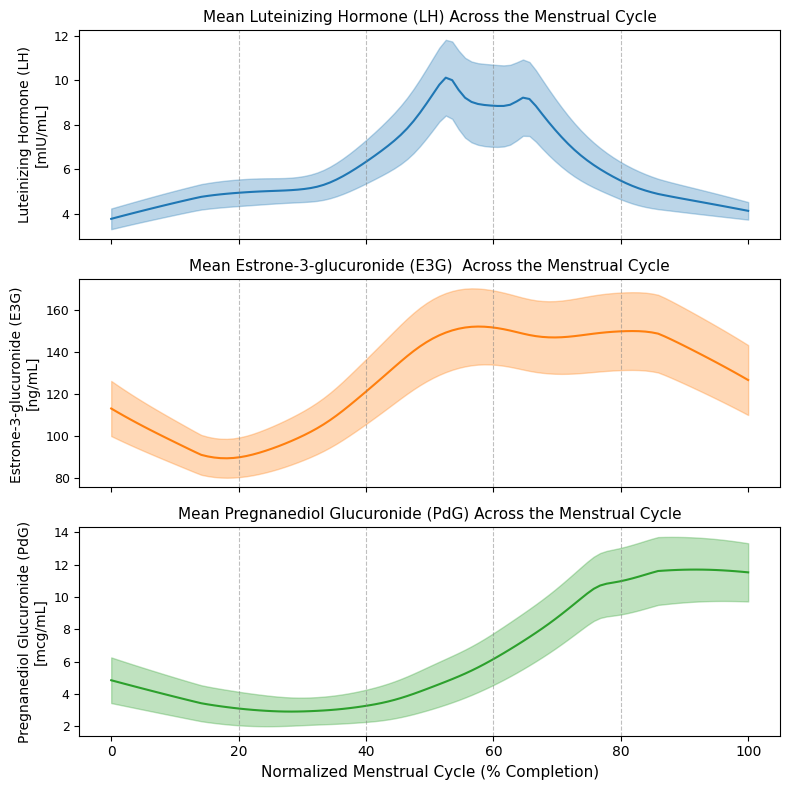

In [ ]:
# Plot hormone curves
signal_labels = {
    'lh': 'Luteinizing Hormone (LH)\n[mIU/mL]',
    'estrogen': 'Estrone-3-glucuronide (E3G) \n[ng/mL]',
    'pdg': 'Pregnanediol Glucuronide (PdG)\n[mcg/mL]'
}

fig, axes = plt.subplots(len(relevant_signals), 1, figsize=(8, 8), sharex=True)

# Loop through each hormone signal
for i, signal in enumerate(relevant_signals):
    color = sns.color_palette()[i]

    # Smooth mean and SEM
    smoothed = lowess(averaged_signals[signal], common_grid, frac=0.3)[:, 1]
    ci = lowess(sem_signals[signal], common_grid, frac=0.3)[:, 1]

    # Plot mean and confidence interval
    axes[i].plot(common_grid, smoothed, label=signal, color=color)
    axes[i].fill_between(common_grid, smoothed - 1.96 * ci, smoothed + 1.96 * ci, color=color, alpha=0.3)

    # Labeling and styling
    axes[i].set_ylabel(signal_labels.get(signal, signal), fontsize=10)
    axes[i].set_title(f'Mean {signal_labels.get(signal, signal).splitlines()[0]} Across the Menstrual Cycle', fontsize=11)
    axes[i].tick_params(axis='y', labelsize=9)
    axes[i].grid(False)

# Final axis and title
axes[-1].set_xlabel('Normalized Menstrual Cycle (% Completion)', fontsize=11)
for ax in axes: # Add vertical reference lines to all subplots
    for v in [20, 40, 60, 80]:
        ax.axvline(x=v, color='gray', linestyle='--', linewidth=0.8, alpha=0.5)
plt.tight_layout()
plt.show()

## 4. Compare Physiological Signals Across Phases


In [ ]:
# Load physiological signals
resting_hr = pd.read_csv('resting_heart_rate.csv')
temperature = pd.read_csv('computed_temperature.csv')

In [ ]:
# Rename sleep_end_day_in_study to day_in_study
temperature = temperature.rename(columns={'sleep_end_day_in_study': 'day_in_study'})

# Filter out zero RHR values
resting_hr = resting_hr[resting_hr['value'] > 0]

# Median per person/day
resting_hr = resting_hr[['id', 'day_in_study', 'value']]
temperature = temperature[['id', 'day_in_study', 'nightly_temperature']]
resting_hr = resting_hr.groupby(['id', 'day_in_study']).min().reset_index()
temperature = temperature.groupby(['id', 'day_in_study']).median().reset_index()

# Merge all physiological signals with the hormone/self-report dataset
merged = hr_and_selfreport.copy()
for df in [resting_hr, temperature]:
    merged = pd.merge(merged, df, on=['id', 'day_in_study'], how='left')

In [ ]:
# Get values per phase per interval
def divide_signal_by_phase(df, signal, phases=['Menstrual', 'Follicular', 'Fertility', 'Luteal']):
    values, labels = [], []
    for source_label, sub_df in [('2022', df[df['study_interval']==2022]), ('2024', df[df['study_interval']==2024])]:
        for phase in phases:
            vals = sub_df[sub_df['phase'] == phase][signal].dropna().tolist()
            values.append(vals)
            labels.append(f'{phase}\n{source_label}')
    return values, labels

# Clip outliers per signal group
def clip_outliers(data_list, lower=0.01, upper=0.99):
    clipped = []
    for values in data_list:
        values_array = np.array(values)
        if len(values_array) == 0:
            clipped.append([])
            continue
        q_low, q_high = np.quantile(values_array, lower), np.quantile(values_array, upper)
        clipped.append(values_array[(values_array >= q_low) & (values_array <= q_high)])
    return clipped

# Extract and clean values
rhr_vals, rhr_labels = divide_signal_by_phase(merged, 'value')
temp_vals, temp_labels = divide_signal_by_phase(merged, 'nightly_temperature')
rhr_vals = clip_outliers(rhr_vals)
temp_vals = clip_outliers(temp_vals)

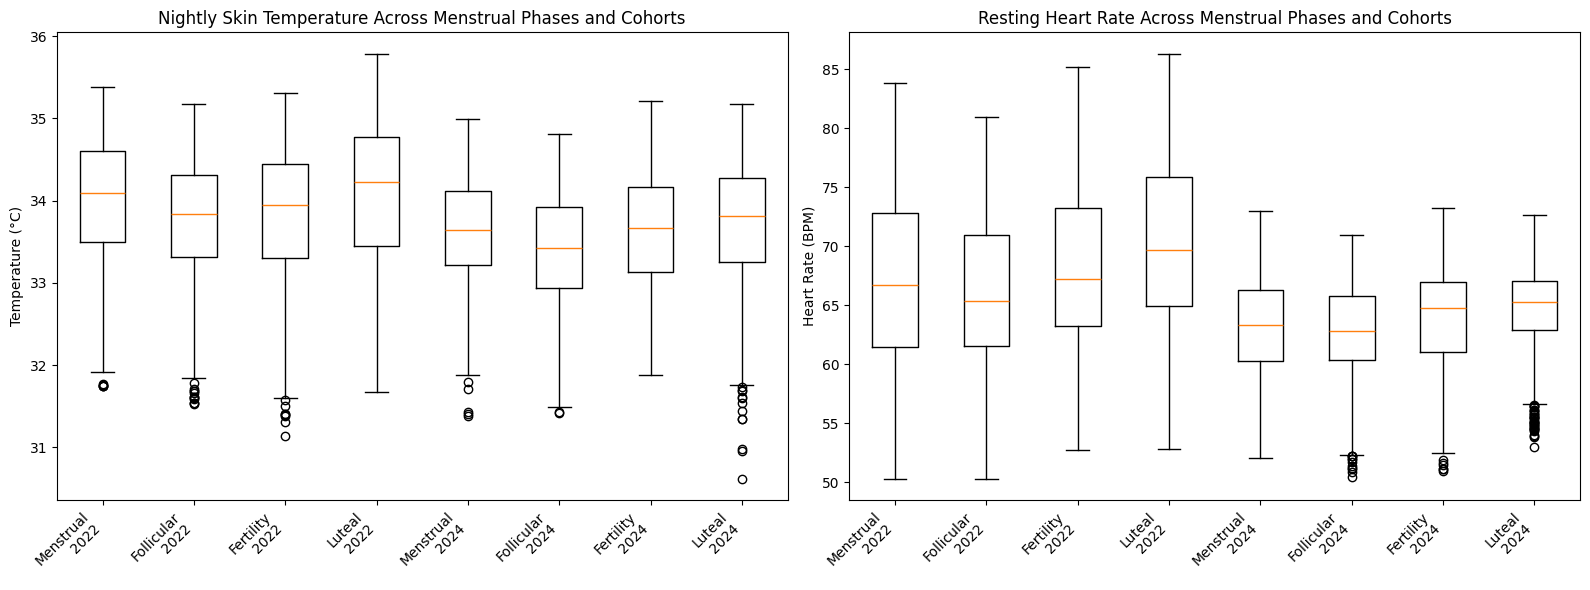

In [ ]:
# Plot comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].boxplot(temp_vals)
axs[0].set_title('Nightly Skin Temperature Across Menstrual Phases and Cohorts', fontsize=12)
axs[0].set_xticklabels(temp_labels, rotation=45, ha='right')
axs[0].set_ylabel('Temperature (°C)', fontsize=10)

axs[1].boxplot(rhr_vals)
axs[1].set_title('Resting Heart Rate Across Menstrual Phases and Cohorts', fontsize=12)
axs[1].set_xticklabels(rhr_labels, rotation=45, ha='right')
axs[1].set_ylabel('Heart Rate (BPM)', fontsize=10)

plt.tight_layout()
plt.show()